## Import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import default_rng

## Data Generation

In [2]:
def sample_index(n,x):
    rng = default_rng()
    # sample 95% index to be 0.
    array_size = np.rint(n*0.95)
    index = rng.choice(n, size=array_size.astype(int), replace=False)
    index = np.sort(index)
    for i in index:
        x[i]=0
    return x

In [3]:
# define a function to generate experimental data.
# Input args: m,n are matrix shape; mu and sigma are for noise data.
def data_generator(m,n,mu, sigma):
    # A is a matrix with size R^{m*n}
    
    A = np.empty([m,n])
    # ground truth 
    original_z = 5*np.random.rand(n,1)
    # Sample sparse vector
    z = sample_index(n,original_z)
    # create noise vector with the length equals to m
    for i in range(m):
        for j in range(n):
            A[i,j] = np.random.normal(mu, 1)
        norm_A_i = np.linalg.norm(A[i,:],2)
        # scale each row of A such that the norm of each row is equal to 1.
        A[i,:] = A[i,:]/norm_A_i
    delta = np.random.normal(mu, sigma, size=(m,1))
    return A, z, delta

In [22]:
# Specify m, n
m = 700 #100;400;700
n = 1000
# Specify the mean and variance of noise \delta, which follows normal distribution.
mu = 0
# This can be changed.
sigma = 0.8
np.random.seed(1234)

In [23]:
A, z, delta = data_generator(m,n,mu,sigma)
# generate observations
b = np.matmul(A,z)+delta
# check about A,z,b's shape
print(A.shape)
print(z.shape)
print(delta.shape)
print(b.shape)
print(np.linalg.norm(A[1,:],2))
print(A.shape[0])

(700, 1000)
(1000, 1)
(700, 1)
(700, 1)
1.0
700


In [24]:
# Check Sparsity of vector z.
print(z[1:20])

[[0.        ]
 [2.1886387 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [4.79069677]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


## LMS and CS Model Set up

In [7]:
# define a function compute least square loss function value.
def least_square(A,x,b):
    residual = np.matmul(A,x)-b
    loss = 0.5*np.linalg.norm(residual,2)**2
    return loss

In [8]:
# define a function compute gradient
def least_square_grad(A,x,b):
    residual = np.matmul(A,x)-b
    # gradient is A^T(Ax-b)
    grad = np.matmul(np.transpose(A),residual)
    return grad

In [9]:
def L1_least_square(A,x,b,lambda0):
    residual = np.matmul(A,x)-b
    loss = 0.5*np.linalg.norm(residual,2)**2
    regularization = lambda0*np.linalg.norm(x,1)
    return loss+regularization

In [10]:
def proximal_operator_L1(x,lambda0):
    u = np.maximum(x-lambda0,0)
    return u*np.sign(u)

In [31]:
def L0_least_square(A,x,b,lambda0):
    residual = np.matmul(A,x)-b
    loss = 0.5*np.linalg.norm(residual,2)**2
    l0_norm = np.sum(x!=0)
    regularization = lambda0*l0_norm
    return loss+regularization

In [11]:
def proximal_operator_L0(x,lambda0):
    length = np.shape(x)[0]
    z = np.zeros((length,1))
    for i in range(length):
        if (1/2)*(x[i]**2) <= lambda0:
            z[i] = 0
        else:
            z[i] = x[i]
    return z
            

## Model Test

In [35]:
## This is test code for mirror descent.
lr = 0.1
x0 = z+3*np.random.normal(0,1,size = (z.shape[0],z.shape[1]))
x_storage = x0
#x0 = x0/np.sum(x0)
#print(x0)
max_iter = 2000
obj_val = np.empty(0)
initial_val = least_square(A,x0,b)
obj_val = np.append(obj_val,initial_val)
estimation_vec = np.empty(0)
#print(obj_val)
for j in range(max_iter):
    grad = least_square_grad(A,x0,b)
    x0 = x0 - lr*grad
    loss = least_square(A,x0,b)
    obj_val = np.append(obj_val,loss)
    est_err = np.linalg.norm(x0-z,2)/np.linalg.norm(z,2)
    estimation_vec = np.append(estimation_vec,est_err)
print(est_err)



3.437325855858798


In [43]:
## This is the test code for project gradient descent.
lr1 = 0.1
lambda0 = 0.1
x1 = x_storage
max_iter = 2000
obj_val1 = np.empty(0)
initial_val1 = least_square(A,x1,b)
obj_val1 = np.append(obj_val1,initial_val1)
estimation_vec1 = np.empty(0)
#print(obj_val1)
for j in range(max_iter):
    grad = least_square_grad(A,x1,b)
    x1_hat = x1 - lr1*grad
    # proximal_gradient
    x1 = proximal_operator_L1(x1_hat,lambda0)
    loss = L1_least_square(A,x1,b,lambda0)
    obj_val1 = np.append(obj_val1,loss)
    est_err1 = np.linalg.norm(x1-z,2)/np.linalg.norm(z,2)
    estimation_vec1 = np.append(estimation_vec1,est_err1)
print(est_err1)

0.5933798503216864


In [44]:
lr2 = 0.1
lambda0 = 3
x2 = x_storage
max_iter = 2000
obj_val2 = np.empty(0)
initial_val2 = least_square(A,x2,b)
obj_val2 = np.append(obj_val2,initial_val1)
estimation_vec2 = np.empty(0)
#print(obj_val1)
for j in range(max_iter):
    grad = least_square_grad(A,x2,b)
    x2_hat = x2 - lr2*grad
    # proximal gradient
    x2 = proximal_operator_L0(x2_hat,lambda0)
    loss = L0_least_square(A,x2,b,lambda0)
    obj_val2 = np.append(obj_val2,loss)
    est_err2 = np.linalg.norm(x2-z,2)/np.linalg.norm(z,2)
    estimation_vec2 = np.append(estimation_vec2,est_err2)
print(est_err2)

0.8015857983396927


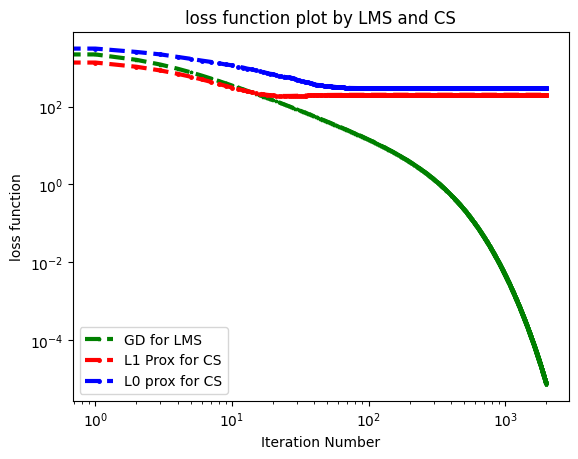

In [34]:
plt.loglog(obj_val, color='green', marker='*', linestyle='dashed',
...      linewidth=3, markersize=2.5,label = 'GD for LMS')
plt.loglog(obj_val1, color='red', marker='o', linestyle='dashed',
...      linewidth=3, markersize=2.5,label = 'L1 Prox for CS')
plt.loglog(obj_val2, color='blue', marker='o', linestyle='dashed',
...      linewidth=3, markersize=2.5,label = 'L0 prox for CS')
plt.legend()
plt.xlabel('Iteration Number')
plt.ylabel('loss function')
plt.title('loss function plot by LMS and CS')
plt.savefig("Visualization of loss function by mirror descent", dpi = 150)

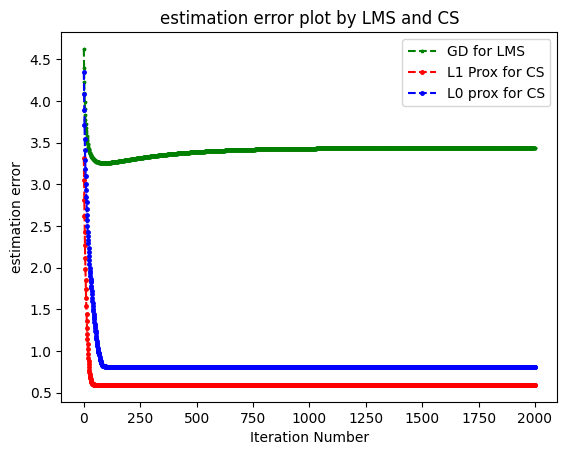

In [46]:
plt.plot(estimation_vec, color='green', marker='*', linestyle='dashed',
...      linewidth=1.5, markersize=2.5,label = 'GD for LMS')
plt.plot(estimation_vec1, color='red', marker='o', linestyle='dashed',
...      linewidth=1.5, markersize=2.5,label = 'L1 Prox for CS')
plt.plot(estimation_vec2, color='blue', marker='o', linestyle='dashed',
...      linewidth=1.5, markersize=2.5,label = 'L0 prox for CS')
plt.legend()
plt.xlabel('Iteration Number')
plt.ylabel('estimation error')
plt.title('estimation error plot by LMS and CS')
plt.savefig("Visualization of loss function by mirror descent", dpi = 150)